In [2]:
#@title
!pip install sympy==1.3
!pip install symfit

import numpy as np
import scipy 
import csv
import sys
import matplotlib.pyplot as plt
from symfit import parameters, variables, sin, cos, Fit
import sympy
import os


  Created wheel for sympy: filename=sympy-1.3-py3-none-any.whl size=5199950 sha256=5f5a8ac7b57df39a94e7de7affa65726d0c48fd45d77afd826fca8ac8b387db3
  Stored in directory: c:\users\dell\appdata\local\pip\cache\wheels\cc\0e\43\16a9db6826096e1d5a8317f7d891e60779d710c61ce7b32a99
Successfully built sympy
  Attempting uninstall: sympy
    Found existing installation: sympy 1.6.1
    Uninstalling sympy-1.6.1:
      Successfully uninstalled sympy-1.6.1
Processing c:\users\dell\appdata\local\pip\cache\wheels\11\00\d8\c321fee9edd43c1468723692ef502cdcd981d4251db5cf3bd6\symfit-0.5.3-py2.py3-none-any.whl
  Using cached toposort-1.5-py2.py3-none-any.whl (7.6 kB)


# Ajuste de superficies de Poincaré utilizando Series de Fourier. 

Se utiliza el método propuesto en el artículo "*Experimental and numerical study of error fields in the CNT stellarator*", DOI:10.1088/0741-3335/58/7/074002. 

En este artículo se debe realizar una parametrización de las secciones de Poincaré debido a que estas son las bases para el cálculo de errores entre la configuración experimental de las bobinas, y el modelo teórico que para el caso SCR-1 es el módulo BSOLCTRA.

El modelo utilizado se basa en realizar un ajuste de la superficie de Poincaré a ciertos parámetros discretizados $X$, los cuales son los coeficientes de una combinación lineal de funciones ortogonales. 

Para una superficie de flujo caracterizada por un $\rho$ arbitrario, se tiene que la expansión trignométrica que la caracteriza está dada por: 

$$R^{\rho}(\theta)=R_{0}^{\rho}+\sum_{m=1}^MR_{cm}^{\rho}\cos(m\theta)+\sum_{m=1}^MR_{sm}^{\rho}\sin(m\theta)$$

$$Z^{\rho}(\theta)=Z_0^{\rho}+\sum_{m=1}^MZ_{cm}^{\rho}\cos(m\theta)+\sum_{m=1}^MZ_{sm}^{\rho}\sin(m\theta)$$

El cálculo de estos parámetros se realiza por medio de el análisis de Fourier, con lo cual para un conjunto de datos discretos $y_i$ en un intervalo de [a,b] que en este caso se tomará por simplicidad el intervalo [0,2$\pi$], se tiene que una función que aproxima estos datos por medio de mínimos cuadrados es:

$$f(x)=\frac{1}{2}A_0+\sum_{k=1}^\infty A_n\cos(kx)+\sum_{k=1}^\infty B_n\sin(kx)$$

Donde los coeficientes $A_n, B_n$ de la serie están dados por: 

$$A_n=\frac{1}{\pi}\int_0^{2\pi}f(x)\cos(nx)dx$$
$$B_n=\frac{1}{\pi}\int_0^{2\pi}f(x)\sin(nx)dx$$
 
La implementación para la serie de datos discretizados se da a continuación:

In [3]:
#Se cargan los datos a analizar

def cargar_datos(file_dir, angle_cut):
    
    angle_cut = angle_cut*np.pi/180
    dphi = 0.01
    phi_up = angle_cut + dphi/2
    phi_down = angle_cut - dphi/2
    R0 = 0.2477 #Radio característico del SCR-1

    data = np.loadtxt(file_dir, dtype=float, skiprows=2, delimiter='\t')
    plotcoord = list()
    #Cilindrical Toroidal Transform
    iRange, _ = data.shape
    for i in range(iRange):
        if data[i,1] > phi_down and data[i,1] < phi_up:
            rtor = data[i,0]
            thetator = data[i,2]
            R = (R0+rtor*np.cos(thetator))
            z = rtor*np.sin(thetator)
            plotcoord.append([R,z,thetator,rtor])
    

    plotcoord = np.array(plotcoord)
    
    print("done")

    return plotcoord

In [ ]:
datos_fourier = cargar_datos("/content/drive/MyDrive/DATASET/resultstoroidal/torpath0077.txt",0)

done


In [ ]:
print(datos_fourier.shape)

(390, 4)


In [ ]:
#Se utiliza el código encontrado en https://stackoverflow.com/questions/52524919/fourier-series-fit-in-python 
#que utliza python simbólico para generar el ajuste

from symfit import parameters, variables, sin, cos, Fit


def fourier_series(x, f, n=0):
    """
    Returns a symbolic fourier series of order `n`.

    :param n: Order of the fourier series.
    :param x: Independent variable
    :param f: Frequency of the fourier series
    """
    # Make the parameter objects for all the terms
    R0, *cos_R_c = parameters(','.join(['R_c{}'.format(i) for i in range(0, n + 1)]))
    sin_R_s = parameters(','.join(['R_s{}'.format(i) for i in range(1, n + 1)]))
    # Construct the series
    series = R0 + sum(R_ci * cos(i * f * x) + R_si * sin(i * f * x)
                     for i, (R_ci, R_si) in enumerate(zip(cos_R_c, sin_R_s), start=1))
    return series, cos_R_c, sin_R_s

x, y = variables('x, y')
w, = parameters('w')
model, R_c, R_s = fourier_series(x, f=1, n=14)
model_dict = {y: model}

print(model_dict)

{y: R_c0 + R_c1*cos(x) + R_c10*cos(10*x) + R_c11*cos(11*x) + R_c12*cos(12*x) + R_c13*cos(13*x) + R_c14*cos(14*x) + R_c2*cos(2*x) + R_c3*cos(3*x) + R_c4*cos(4*x) + R_c5*cos(5*x) + R_c6*cos(6*x) + R_c7*cos(7*x) + R_c8*cos(8*x) + R_c9*cos(9*x) + R_s1*sin(x) + R_s10*sin(10*x) + R_s11*sin(11*x) + R_s12*sin(12*x) + R_s13*sin(13*x) + R_s14*sin(14*x) + R_s2*sin(2*x) + R_s3*sin(3*x) + R_s4*sin(4*x) + R_s5*sin(5*x) + R_s6*sin(6*x) + R_s7*sin(7*x) + R_s8*sin(8*x) + R_s9*sin(9*x)}


In [ ]:
def fit_poincare(datos):
    iRange = len(datos)
    results = list()

    rdata, zdata, theta, minorradius = datos.T
    # Define a Fit object for this model and data
    Rfit = Fit(model_dict, x=theta, y=rdata)
    Rfit_result = Rfit.execute()
    Zfit = Fit(model_dict, x=theta, y=zdata)
    Zfit_result = Zfit.execute()
    results.append([Zfit_result.params,Rfit_result.params])
    plt.scatter(rdata, zdata, marker='.', s=1.8, c="black")
    plt.scatter(Rfit.model(x=theta, **Rfit_result.params).y, Zfit.model(x=theta, **Zfit_result.params).y, color='red', ls=':',marker='.', s=1.5)
    plt.show()

    return results
# Resultado para R

#fit_poincare(datos_fourier)





done
Feedback: torpath0013.txt
done
Feedback: torpath0014.txt
done
Feedback: torpath0020.txt
done
Feedback: torpath0022.txt
done
Feedback: torpath0023.txt
done
Feedback: torpath0024.txt
done
Feedback: torpath0026.txt
done
Feedback: torpath0029.txt
done
Feedback: torpath0030.txt
done
Feedback: torpath0033.txt
done
Feedback: torpath0035.txt
done
Feedback: torpath0036.txt
done
Feedback: torpath0037.txt
done
Feedback: torpath0044.txt
done
Feedback: torpath0045.txt
done
Feedback: torpath0047.txt
done
Feedback: torpath0048.txt
done
Feedback: torpath0049.txt
done
Feedback: torpath0051.txt
done
Feedback: torpath0054.txt
done
Feedback: torpath0064.txt
done
Feedback: torpath0068.txt
done
Feedback: torpath0070.txt
done
Feedback: torpath0072.txt
done
Feedback: torpath0073.txt
done
Feedback: torpath0074.txt
done
Feedback: torpath0076.txt
done
Feedback: torpath0077.txt
done
Feedback: torpath0085.txt
done
Feedback: torpath0091.txt
done
Feedback: torpath0093.txt
done
Feedback: torpath0094.txt
done
Fee

/usr/local/lib/python3.6/dist-packages/symfit/core/fit_results.py:277: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - SS_res/SS_tot


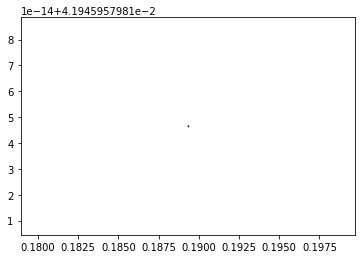

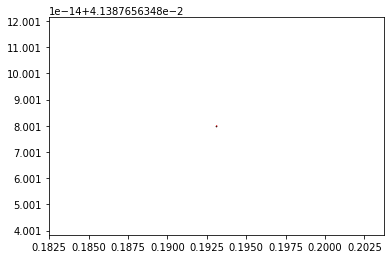

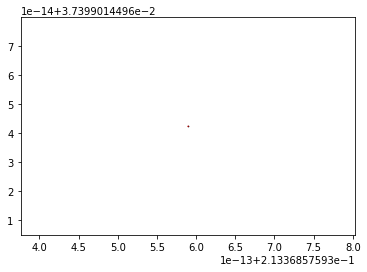

/usr/local/lib/python3.6/dist-packages/symfit/core/fit_results.py:277: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - SS_res/SS_tot


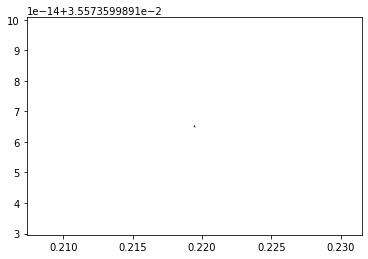

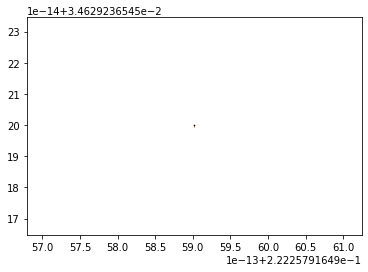

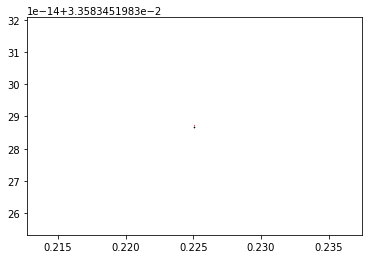

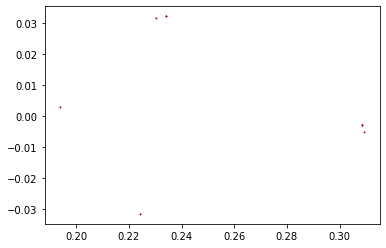

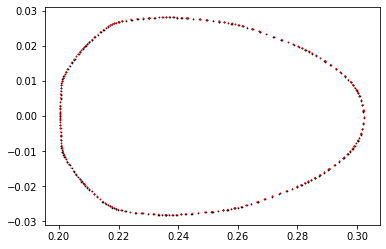

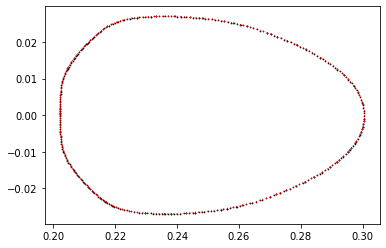

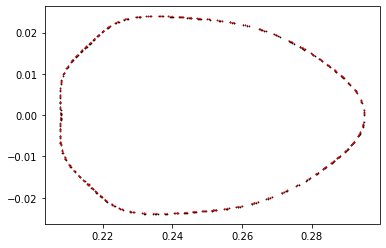

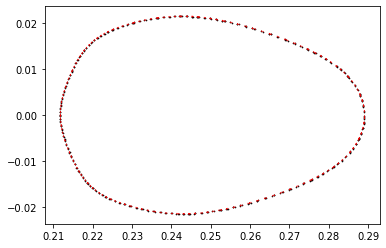

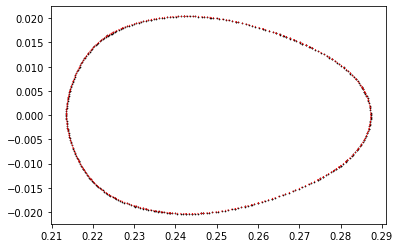

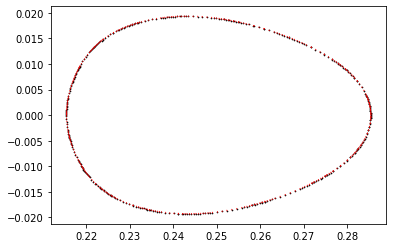

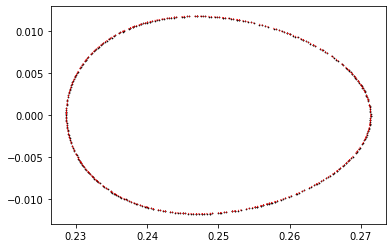

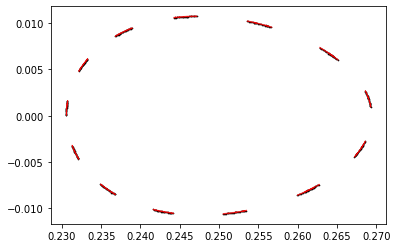

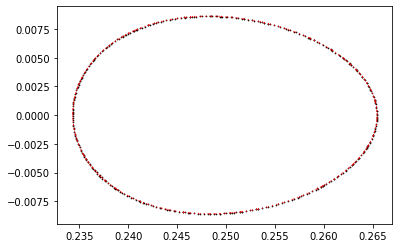

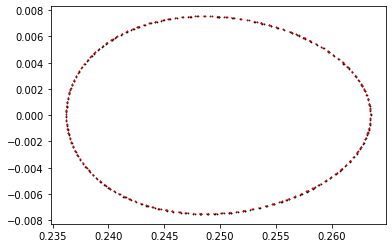

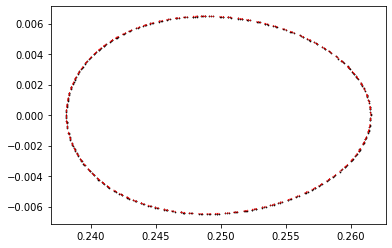

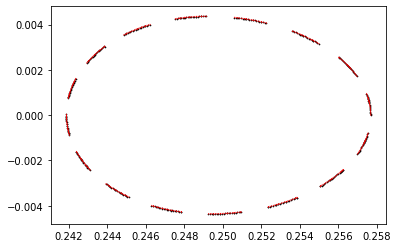

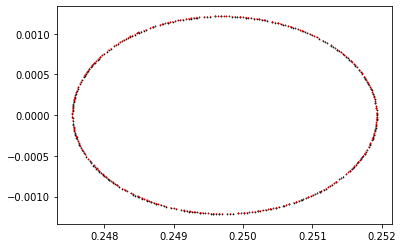

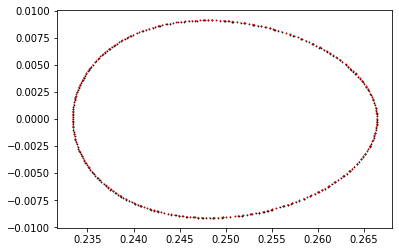

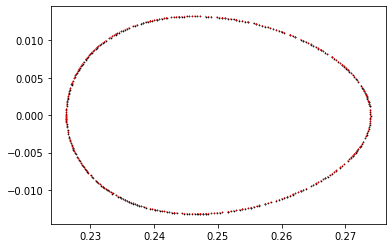

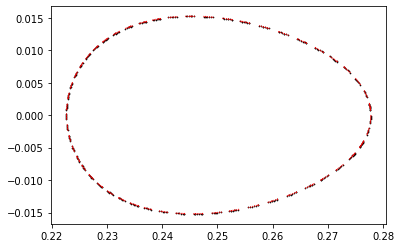

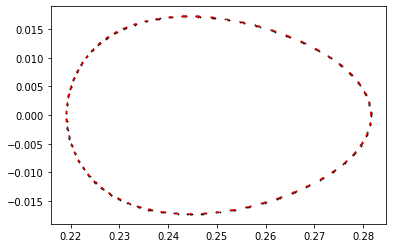

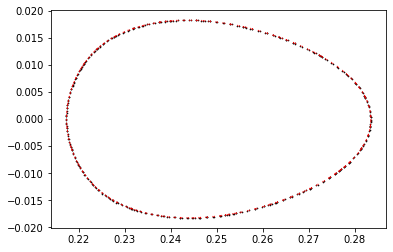

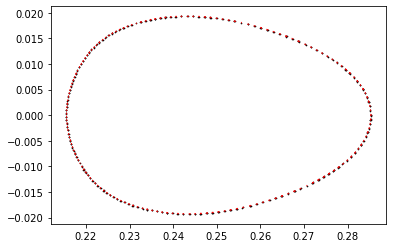

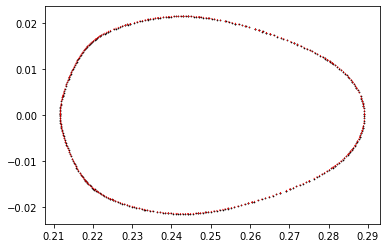

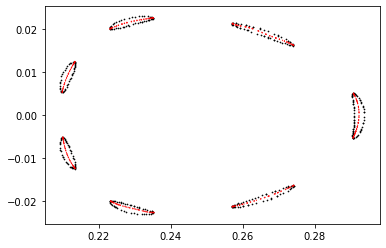

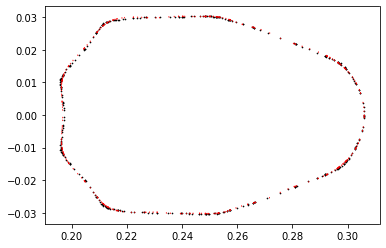

/usr/local/lib/python3.6/dist-packages/symfit/core/fit_results.py:277: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - SS_res/SS_tot


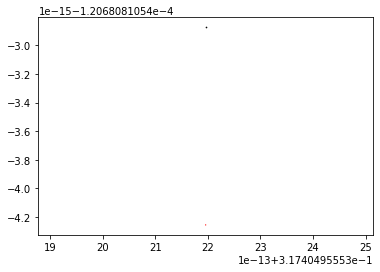

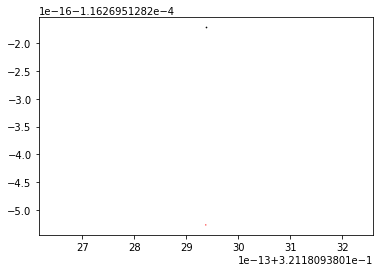

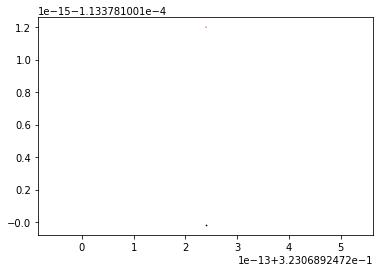

ValueError: ignored

In [ ]:
def analyze_directory(dir_path, angle): 
    main_dir = os.getcwd()
    list_archiv = os.listdir(dir_path)
    list_archiv.sort()
    poincare_coords = list()
    os.chdir(dir_path)

    for iArch in list_archiv:
        poincare_coords.append(cargar_datos(iArch, angle))
        print("Feedback: "+str(iArch))
    
    poincare_coords = np.array(poincare_coords)
    iRange = len(poincare_coords)
    fourier_series_params = list()

    for i in range(iRange):
        if len(poincare_coords[i]) != 0: 
            fourier_series_params.append(fit_poincare(poincare_coords[i]))
        else: 
            continue   
    
    return fourier_series_params

analyze_directory("/content/drive/MyDrive/DATASET/resultstoroidal", 0)




